## Week 13 Lecture 2

Remember that we used linear regression to predict quantitative variables. We can use logistic regression to predict qualitative variables. Following an exercise about standard units, we will use logistic regression to understand some sports statistics. 

In [156]:
# import packages 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from scipy.optimize import minimize

from helper_functions import *

# change settings

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

# import for configuration

from IPython.display import Image

### Exercise (Standard Units)

Suppose we have the following table.

In [157]:
table = pd.DataFrame(data = {
    "Explanatory Variable Small" : np.random.randint(0,9, 1000) / 10,
    "Explanatory Variable Large" : np.random.randint(100,999, 1000)
})
table["Response Variable"] = np.dot(table, np.array([51.78, 0.014]))

table

,Explanatory Variable Small,Explanatory Variable Large,Response Variable
0,0.6,100,32.468
1,0.4,492,27.600
2,0.8,540,48.984
3,0.7,386,41.650
4,0.2,106,11.840
...,...,...,...
995,0.4,561,28.566
996,0.1,568,13.130
997,0.5,857,37.888
998,0.8,799,52.610


Here we have 1000 records with 3 features. The relationship between features is 

$$\text{Response Variable} = 51.78 * \text{Explanatory Variable Small} + 0.014 * \text{Explanatory Variable Large}$$

Note that the features have different scales. 

 Varaible | Order of Magnitude 
 --- | ---
 `Responses Variable` | $10^1$
 `Explanatory Variable Small` | $10^{-1}$
 `Explanatory Variable Large` | $10^{2}$

We can try to infer the slopes 51.78 and 0.014 with a linear model

$$\text{Response Variable} = w_0 * \text{Explanatory Variable Small} + w_1 * \text{Explanatory Variable Large}$$

We expect $w_0 * \text{Explanatory Variable Small}$ and $w_1 * \text{Explanatory Variable Large}$ to have approximately the order of magnitude of $\text{Response Variable}$. So 

 Varaible | Order of Magnitude 
 --- | ---
$w_0$ | at least $10^1$
$w_1$ | at most $10^{-1}$

So the large features should have small slopes and the small features should have large slopes. 

In [3]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(table.drop(columns = ["Response Variable"]), table["Response Variable"])
linear_model.coef_

array([5.178e+01, 1.400e-02])

Using the scikit-learn package we have obtained 5.17 and 0.014 for the slopes. However, if we try either Ridge Regression or Lasso Regression, then we obtain different slopes. 

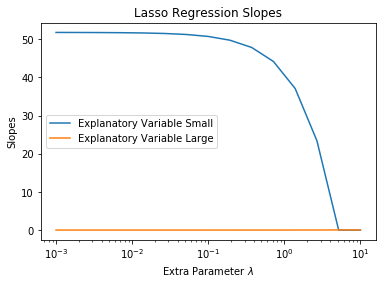

In [4]:
plot_lasso_models(table)

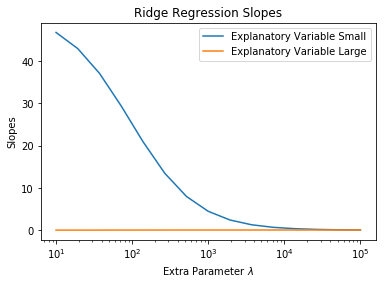

In [5]:
plot_ridge_models(table)

Remember that Ridge Regression and Lasso Regression try to shrink large parameters. Since the slope for `Explanatory Variable Small` is larger than the slope for `Exaplanatory Variable Small`, the slope for `Explanatory Variable Small` changes much more than `Explanatory Variable Small`. 

When we use regularization in a model, we should transform features to standard units to avoid differences between scales.  

In [7]:
def transform_to_standard_unit(array):
    return (array - np.mean(array)) / np.std(array) 

table_standard_units = table.apply(transform_to_standard_unit)
table_standard_units

,Explanatory Variable Small,Explanatory Variable Large,Response Variable
0,-1.566880,0.346042,-1.427841
1,-1.174768,0.548572,-0.994219
2,1.177905,-0.635450,0.974333
3,1.570017,0.525204,1.660815
4,0.393681,-0.323865,0.296220
...,...,...,...
995,-0.782656,-1.367675,-1.119768
996,-1.566880,1.592382,-1.098917
997,0.785793,0.708260,0.948782
998,-0.782656,-1.581889,-1.176302


Now regularization affects both explanatory variables in the same way.

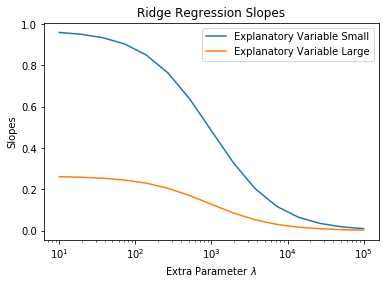

In [8]:
plot_ridge_models(table_standard_units)

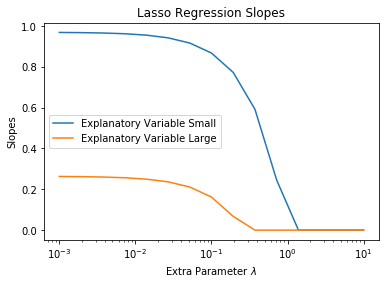

In [9]:
plot_lasso_models(table_standard_units)

### Example (Binned Regression)

We will use a dataset about the National Basketball Association.

In [30]:
nba = pd.read_csv("nba.csv")
nba 

,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,FGM,FGA,FG_PCT,WON
0,Golden State Warriors,21800002,2018-10-16,GSW vs. OKC,42,95,0.442,1
1,Oklahoma City Thunder,21800002,2018-10-16,OKC @ GSW,33,91,0.363,0
2,Philadelphia 76ers,21800001,2018-10-16,PHI @ BOS,34,87,0.391,0
3,Boston Celtics,21800001,2018-10-16,BOS vs. PHI,42,97,0.433,1
4,Minnesota Timberwolves,21800010,2018-10-17,MIN @ SAS,39,91,0.429,0
...,...,...,...,...,...,...,...,...
2455,Denver Nuggets,21801228,2019-04-10,DEN vs. MIN,39,87,0.448,1
2456,Orlando Magic,21801222,2019-04-10,ORL @ CHA,48,88,0.545,1
2457,Charlotte Hornets,21801222,2019-04-10,CHA vs. ORL,41,78,0.526,0
2458,Memphis Grizzlies,21801225,2019-04-10,MEM vs. GSW,48,98,0.490,1


Note that in the `WON` column 1 indicates a win and 0 indicates a loss. Note that the `FG_PCT` column calculates 

$$\displaystyle \frac{Shots Scored}{Shots Attempted}$$

So `FC_PCT` measures the accuracy of players' shots.

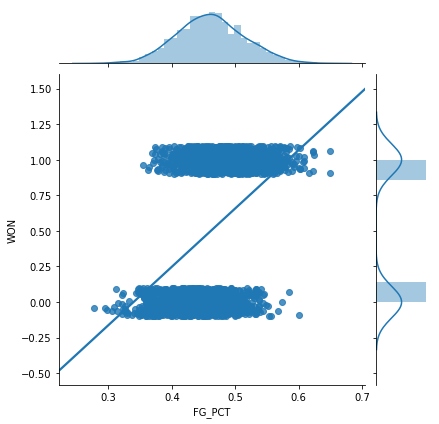

In [32]:
sns.jointplot(data = nba, x = "FG_PCT", y = "WON", kind = "reg", y_jitter = 0.1, ci = 0);

We find that linear regression cannot capture the pattern in the data because we lack a linear shape. Before we try a transformation to bend the line, we should modify the explanatory variable `FG_PCT`. Instead of the accuracy of players' shots, we should compute the relative accuracy of players' shots between the two teams. Note that games are labeled by `GAME_ID`.

In [159]:
nba.groupby("GAME_ID").size()

GAME_ID
21800001    2
21800002    2
21800003    2
21800004    2
21800005    2
           ..
21801226    2
21801227    2
21801228    2
21801229    2
21801230    2
Length: 1230, dtype: int64

In [ ]:
for game_id, subframe in nba.groupby("GAME_ID"):
    print(game_id)
    print(subframe)

So we should split the first and second entries for each number in the `GAME_ID` column. 

In [163]:
first_team = nba.groupby("GAME_ID").head(1)
first_team = first_team[["GAME_ID", "TEAM_NAME", "FG_PCT", "WON"]]
first_team

,GAME_ID,TEAM_NAME,FG_PCT,WON
0,21800002,Golden State Warriors,0.442,1
2,21800001,Philadelphia 76ers,0.391,0
4,21800010,Minnesota Timberwolves,0.429,0
6,21800007,New York Knicks,0.455,1
8,21800013,Dallas Mavericks,0.432,0
...,...,...,...,...
2450,21801220,Atlanta Hawks,0.417,0
2452,21801226,Milwaukee Bucks,0.430,0
2454,21801228,Minnesota Timberwolves,0.429,0
2456,21801222,Orlando Magic,0.545,1


In [164]:
second_team = nba.groupby("GAME_ID").tail(1)
second_team = second_team[["GAME_ID", "TEAM_NAME", "FG_PCT", "WON"]]
second_team

,GAME_ID,TEAM_NAME,FG_PCT,WON
1,21800002,Oklahoma City Thunder,0.363,0
3,21800001,Boston Celtics,0.433,1
5,21800010,San Antonio Spurs,0.430,1
7,21800007,Atlanta Hawks,0.456,0
9,21800013,Phoenix Suns,0.543,1
...,...,...,...,...
2451,21801220,Indiana Pacers,0.459,1
2453,21801226,Oklahoma City Thunder,0.485,1
2455,21801228,Denver Nuggets,0.448,1
2457,21801222,Charlotte Hornets,0.526,0


Now we can take an inner join to match the two teams for each game.

In [165]:
games = pd.merge(left = first_team, right = second_team, left_on = "GAME_ID", right_on = "GAME_ID",
                suffixes = ["_FIRST", "_SECOND"])
games

,GAME_ID,TEAM_NAME_FIRST,FG_PCT_FIRST,WON_FIRST,TEAM_NAME_SECOND,FG_PCT_SECOND,WON_SECOND
0,21800002,Golden State Warriors,0.442,1,Oklahoma City Thunder,0.363,0
1,21800001,Philadelphia 76ers,0.391,0,Boston Celtics,0.433,1
2,21800010,Minnesota Timberwolves,0.429,0,San Antonio Spurs,0.430,1
3,21800007,New York Knicks,0.455,1,Atlanta Hawks,0.456,0
4,21800013,Dallas Mavericks,0.432,0,Phoenix Suns,0.543,1
...,...,...,...,...,...,...,...
1225,21801220,Atlanta Hawks,0.417,0,Indiana Pacers,0.459,1
1226,21801226,Milwaukee Bucks,0.430,0,Oklahoma City Thunder,0.485,1
1227,21801228,Minnesota Timberwolves,0.429,0,Denver Nuggets,0.448,1
1228,21801222,Orlando Magic,0.545,1,Charlotte Hornets,0.526,0


With both teams, we can compute the relative accuracy of shots as the difference of `FG_PCT`.

In [166]:
games["FG_PCT_DIFF"] = games["FG_PCT_FIRST"] - games["FG_PCT_SECOND"]
games

,GAME_ID,TEAM_NAME_FIRST,FG_PCT_FIRST,WON_FIRST,TEAM_NAME_SECOND,FG_PCT_SECOND,WON_SECOND,FG_PCT_DIFF
0,21800002,Golden State Warriors,0.442,1,Oklahoma City Thunder,0.363,0,0.079
1,21800001,Philadelphia 76ers,0.391,0,Boston Celtics,0.433,1,-0.042
2,21800010,Minnesota Timberwolves,0.429,0,San Antonio Spurs,0.430,1,-0.001
3,21800007,New York Knicks,0.455,1,Atlanta Hawks,0.456,0,-0.001
4,21800013,Dallas Mavericks,0.432,0,Phoenix Suns,0.543,1,-0.111
...,...,...,...,...,...,...,...,...
1225,21801220,Atlanta Hawks,0.417,0,Indiana Pacers,0.459,1,-0.042
1226,21801226,Milwaukee Bucks,0.430,0,Oklahoma City Thunder,0.485,1,-0.055
1227,21801228,Minnesota Timberwolves,0.429,0,Denver Nuggets,0.448,1,-0.019
1228,21801222,Orlando Magic,0.545,1,Charlotte Hornets,0.526,0,0.019


We the new feature `FG_PCT_DIFF` we find some separation between wins anad losses

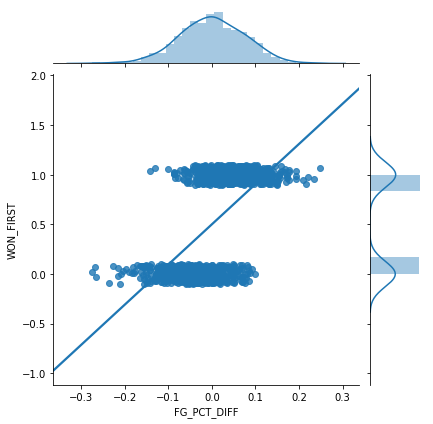

In [168]:
sns.jointplot(data = games, x = "FG_PCT_DIFF", y = "WON_FIRST", kind="reg", y_jitter = 0.1, ci = 0);

Remember from the study of crab shells that we can group together rows of the tables to summarize with statistics like the median and mean.  

In [170]:
bins = pd.cut(games["FG_PCT_DIFF"], 20)
games["bin"] = bins
games

,GAME_ID,TEAM_NAME_FIRST,FG_PCT_FIRST,WON_FIRST,...,FG_PCT_SECOND,WON_SECOND,FG_PCT_DIFF,bin
0,21800002,Golden State Warriors,0.442,1,...,0.363,0,0.079,"(0.0656, 0.0918]"
1,21800001,Philadelphia 76ers,0.391,0,...,0.433,1,-0.042,"(-0.0654, -0.0392]"
2,21800010,Minnesota Timberwolves,0.429,0,...,0.430,1,-0.001,"(-0.013, 0.0132]"
3,21800007,New York Knicks,0.455,1,...,0.456,0,-0.001,"(-0.013, 0.0132]"
4,21800013,Dallas Mavericks,0.432,0,...,0.543,1,-0.111,"(-0.118, -0.0916]"
...,...,...,...,...,...,...,...,...,...
1225,21801220,Atlanta Hawks,0.417,0,...,0.459,1,-0.042,"(-0.0654, -0.0392]"
1226,21801226,Milwaukee Bucks,0.430,0,...,0.485,1,-0.055,"(-0.0654, -0.0392]"
1227,21801228,Minnesota Timberwolves,0.429,0,...,0.448,1,-0.019,"(-0.0392, -0.013]"
1228,21801222,Orlando Magic,0.545,1,...,0.526,0,0.019,"(0.0132, 0.0394]"


The `cut` function allows use to break up the numbers in `FG_PCT_DIFF` into ranges. We can take the median value in the range.

In [174]:
bin_centers = [(b.left + b.right)/2 for b in bins]
games["bin"] = bin_centers
games

,GAME_ID,TEAM_NAME_FIRST,FG_PCT_FIRST,WON_FIRST,...,FG_PCT_SECOND,WON_SECOND,FG_PCT_DIFF,bin
0,21800002,Golden State Warriors,0.442,1,...,0.363,0,0.079,0.0787
1,21800001,Philadelphia 76ers,0.391,0,...,0.433,1,-0.042,-0.0523
2,21800010,Minnesota Timberwolves,0.429,0,...,0.430,1,-0.001,0.0001
3,21800007,New York Knicks,0.455,1,...,0.456,0,-0.001,0.0001
4,21800013,Dallas Mavericks,0.432,0,...,0.543,1,-0.111,-0.1048
...,...,...,...,...,...,...,...,...,...
1225,21801220,Atlanta Hawks,0.417,0,...,0.459,1,-0.042,-0.0523
1226,21801226,Milwaukee Bucks,0.430,0,...,0.485,1,-0.055,-0.0523
1227,21801228,Minnesota Timberwolves,0.429,0,...,0.448,1,-0.019,-0.0261
1228,21801222,Orlando Magic,0.545,1,...,0.526,0,0.019,0.0263



For each range, we want to compute the fraction of games won throughout the season. 

In [175]:
# determine the fraction of wins

def win_rate(win_series):
    num_wins = sum(win_series)
    num_played = len(win_series)
    return num_wins / num_played

# win rates by team

nba.groupby("TEAM_NAME").agg({"WON" : win_rate}).sort_values("WON")

,WON
TEAM_NAME,
New York Knicks,0.207317
Phoenix Suns,0.231707
Cleveland Cavaliers,0.231707
Chicago Bulls,0.268293
Atlanta Hawks,0.353659
...,...
Houston Rockets,0.646341
Denver Nuggets,0.658537
Golden State Warriors,0.695122


The function `win_rate` allows us to compute the fraction of games won. For example we can compute the fraction of games won by each team or for records in each bin. 

In [176]:
binned_win_rates = games.groupby("bin").agg({"WON_FIRST" : win_rate})
binned_win_rates.rename(columns = {"WON_FIRST" : "WIN_RATE"}, inplace = True)
binned_win_rates

,WIN_RATE
bin,
-0.2625,0.0
-0.2360,0.0
-0.2095,0.0
-0.1830,0.0
-0.1570,0.0
...,...
0.1310,1.0
0.1570,1.0
0.1835,1.0


So for each bin we compute the average in the `WON_FIRST` column to determine the fraction of games won among these records.

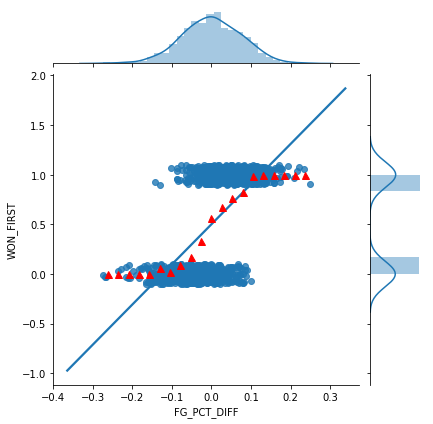

In [105]:
sns.jointplot(data = games, x = "FG_PCT_DIFF", y = "WON_FIRST", kind="reg", y_jitter = 0.1, ci = 0)
plt.plot(binned_win_rates.index, binned_win_rates["WIN_RATE"], 'r^', linewidth = 2, markersize = 7);

Plotting the values for each bin, we obtain binned regression of the data. How can we connect these points?

### Sigmoid Function

Since we cannot use a line, we need a curve to connect the points. 

In [177]:
def sigma(t):
    return 1 / (1 + np.exp(-t))

The sigmoid function is an S-shaped curve

$$\sigma(t) = \displaystyle \frac{1}{1 + e^{-t}}$$

If we use $\sigma(w \cdot t)$ then we can change the shape of the curve.

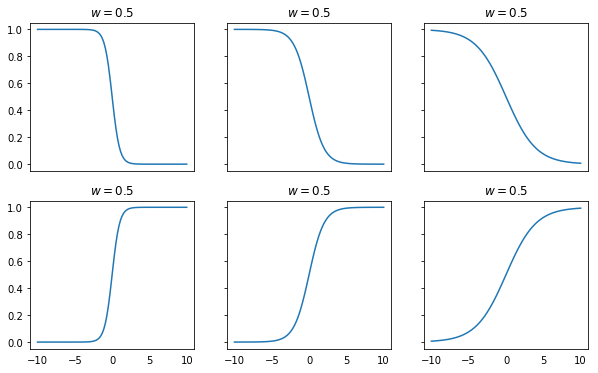

In [189]:
def flatten(li): 
    return [item for sub in li for item in sub]

bs = [-2, -1, -0.5, 2, 1, 0.5]
xs = np.linspace(-10, 10, 100)

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6))
for ax, w in zip(flatten(axes), bs):
    ys = sigma(xs * w)
    ax.plot(xs, ys)
    ax.set_title(r'$ w = $' + str(b))
    ax.tick_params(axis = 'x', bottom = False, top = False, left = False, right = False)    


We can try the value $w = 30$. 

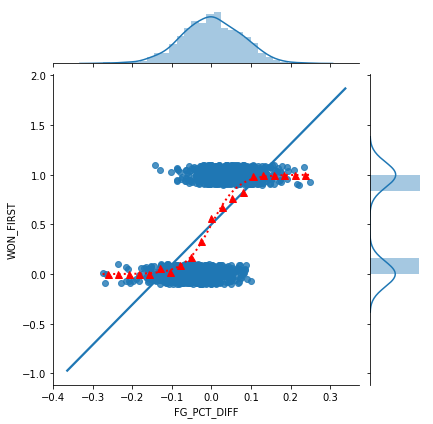

In [107]:
sns.jointplot(data = games, x = "FG_PCT_DIFF", y = "WON_FIRST", kind="reg", y_jitter = 0.1, ci = 0)
plt.plot(binned_win_rates.index, binned_win_rates["WIN_RATE"], 'r^', linewidth = 2, markersize = 7);
x = np.sort(games["FG_PCT_DIFF"])
plt.plot(x, sigma(x * 30), 'r:', linewidth = 2);

We obtain a good fit.

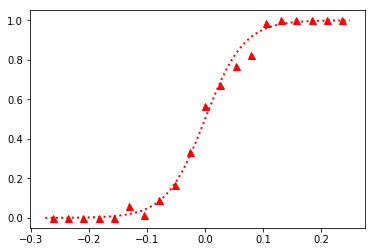

In [108]:
plt.plot(binned_win_rates.index, binned_win_rates["WIN_RATE"], 'r^', linewidth = 2, markersize = 7);
x = np.sort(games["FG_PCT_DIFF"])
plt.plot(x, sigma(x * 30), 'r:', linewidth = 2);

In [194]:
binned_win_rates.iloc[10:, :]

,WIN_RATE
bin,
0.0001,0.566667
0.0263,0.673333
0.0525,0.767442
0.0787,0.824074
0.1049,0.986667
0.1310,1.000000
0.1570,1.000000
0.1835,1.000000
0.2100,1.000000


In [195]:
1 - 0.767

0.23299999999999998

Consider the bin of `FG_PCT_DIFF` with median value 0.0525. We can interpret the fraction 0.767 of wins as a probability 

$$P(\text{WON_FIRST} = 1 \; | \; \text{FG_PCT_DIFF} = 0.15350) = 0.767$$ 

By the complement rule, we have

$$P(\text{WON_FIRST} = 0 \; | \; \text{FG_PCT_DIFF} = 0.15350) = 1 - 0.767 = 0.2329$$ 

So the odds ratio of a win is

$$\displaystyle \frac{0.767}{0.2329}$$

In [115]:
odds_by_bin = (binned_win_rates) / (1 - binned_win_rates)
odds_by_bin

,WIN_RATE
bin,
-0.2625,0.0
-0.2360,0.0
-0.2095,0.0
-0.1830,0.0
-0.1570,0.0
...,...
0.1310,inf
0.1570,inf
0.1835,inf


We can compute the odds ratio for each bin.

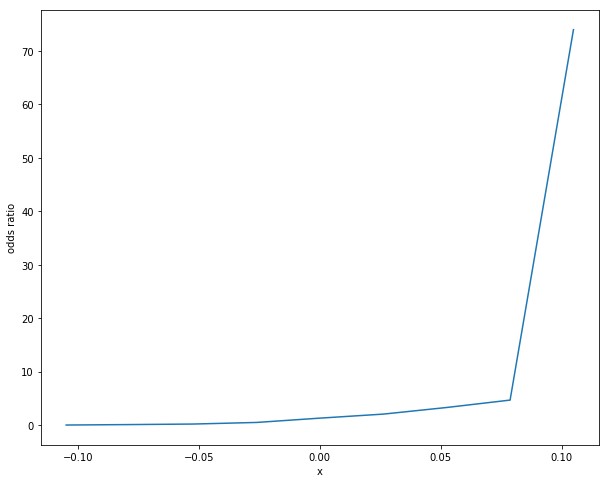

In [198]:
plt.plot(odds_by_bin.iloc[6:20,:])
plt.ylabel('odds ratio')
plt.xlabel('x');

While the odds ration of win to loss does not resemble a line, the logarithmic transformation does resemble a line.

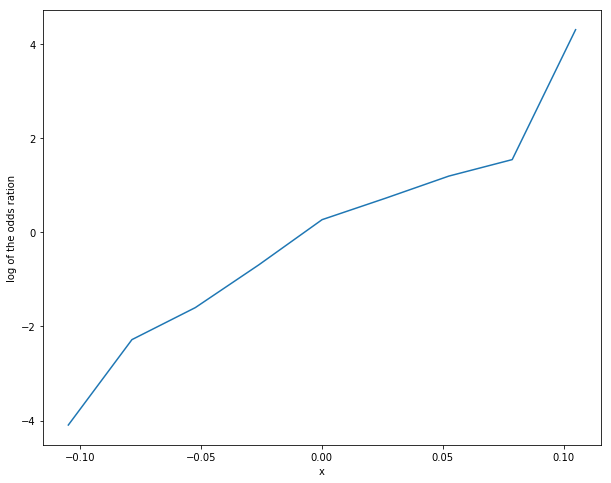

In [199]:
plt.plot(np.log(odds_by_bin + 1e-10).iloc[6:20,:])
plt.ylabel('log of the odds ration')
plt.xlabel('x');

What does this tell us about the sigmoid function? Suppose the slope of the line is $w$. Represent `WON_FIRST` by $Y$ and `FG_PCT_DIFF` by $X$. We have the logarithmic transformation of the odds ratio is linear

$$\log \left( \frac{P(Y=1|X)}{P(Y=0|X)} \right) = w X $$

If we abbreviate $P(Y=1|X)$ as $p$ and $X w$ as $t$ then:

\begin{align*}
\log \left( \frac{p}{1-p} \right) &= t && \text{; complement rule} \\[10pt]
\frac{p}{1-p} &= \exp(t) && \text{; exponentiate both sides} \\[10pt]
p &= \exp(t) - p \exp(t) && \text{; multiply by $1-p$} \\[10pt]
p (1 + \exp(t)) &= \exp(t) && \text{; add $p \exp(t)$ and factor out $p$} \\[10pt]
p &= \frac{\exp(t)}{1 + \exp(t)} && \text{; divide by $1 + \exp(t)$} \\[10pt]
p &= \frac{1}{1 + \exp(-t)} && \text{; multiply by $\frac{\exp(-t)}{\exp(-t)}$} \\[10pt]
\end{align*}

So we have 

$$P(Y=1|X) = \frac{1}{1 + \exp(- w X)} $$

The probability of a win given the relative field goal percentage between the teams is the sigmoid function. We just need to determine a value of the parameter $w$ from the data.

### Logistic Loss Function

Above, we showed that under the assumption the logarithmic transformation of the odds ratio is a line in the variable X, the relationship between our prediction $P(Y = 1 | X)$ and $X$ should be given by:

$$P(Y=1 \; | \; X) = \frac{1}{1 + \exp(-X w)} = \sigma(X w)$$

We can determine $w$ with the same approaches from linear regression. We pick a loss function and we try to minimize the average loss. We could even add a regularization term.

In [201]:
def mse_loss_single_arg(w):
    x = games["FG_PCT_DIFF"]
    y_obs = games["WON_FIRST"]
    y_hat = sigma(x * w)
    return np.mean((y_obs - y_hat)**2)

We could try the square loss. So each choice of $w$ would determine a mean square error. 

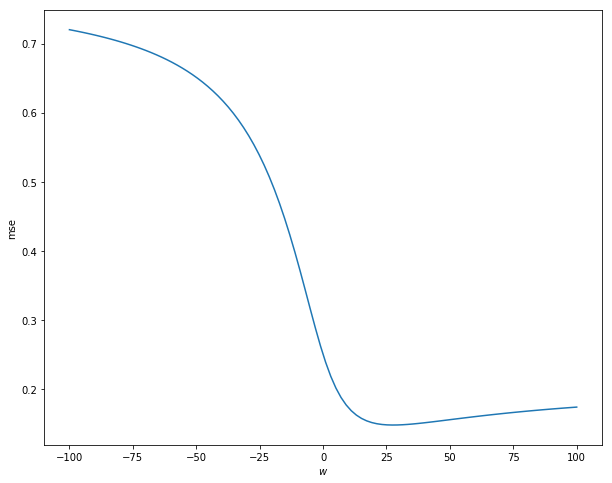

In [204]:
w_values = np.linspace(-100, 100, 100)
plt.plot(w_values, [mse_loss_single_arg(w) for w in w_values])
plt.ylabel('mse')
plt.xlabel(r'$w$');

We can use the `minimize` function in the scipy package to find the minimum value.

In [205]:
minimize(mse_loss_single_arg, x0 = 0).x

array([27.51848698])

Note that we have a somewhat flat region for large values of $w$. For other datasets we could have a flatter function.

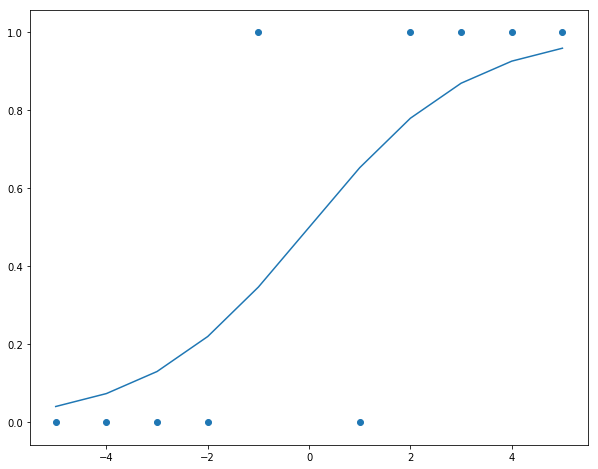

In [210]:
example_table = pd.DataFrame({
    'X': [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
    'Y': [ 0,  0,  0,  0,  1, 0, 1, 1, 1, 1]
})
plt.scatter(example_table['X'], example_table['Y'])
plt.plot(toy['X'], sigma(example_table['X'] * 0.63255911));

With square loss the mean square error as a function of $w$ can be very flat.

In [211]:
def mse_loss_single_arg_example(w):
    x = example_table['X']
    y_obs = example_table['Y']
    y_hat = sigma(w * x)
    return np.mean((y_hat - y_obs) ** 2)    

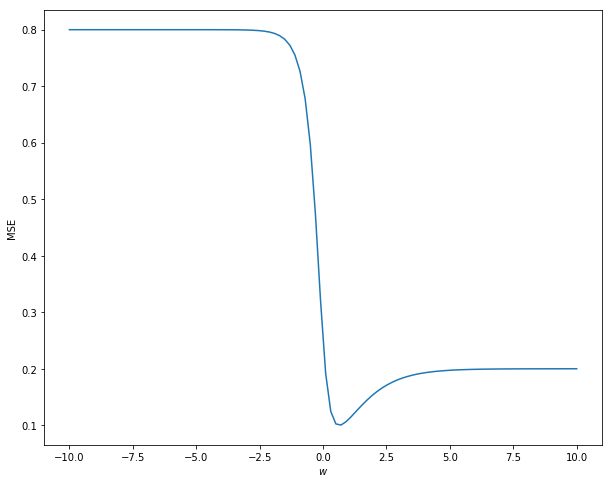

In [212]:
w_values = np.linspace(-10, 10, 100)
plt.plot(w_values, [mse_loss_single_arg_example(w) for w in w_values])
plt.ylabel('MSE')
plt.xlabel(r'$w$');

We would have trouble with gradient descent because the guesses would get stuck in the flat region where the derivative is 0. An alternate loss function often used for logistic regression is the logisitic loss.

$$\text{loss} = -y \log(\hat{y}) - (1-y)\log(1-\hat{y})$$

Here $y$ is the observed value and $\hat{y}$ is the predicted value. In our case, since y is always either 0 or 1, we can also write the logistic loss as:

$$\textrm{loss} = \begin{cases}
-\log(1 - \hat{y}) & y = 0 \\
-\log(\hat{y}) & y = 1
\end{cases}$$

These two formulations are exactly identical. Even though the second is more clear conceptually, we will tend to use the first one for consistency. To get some intuition for what this loss function means, consider the plot below of the case where $y = 1$.

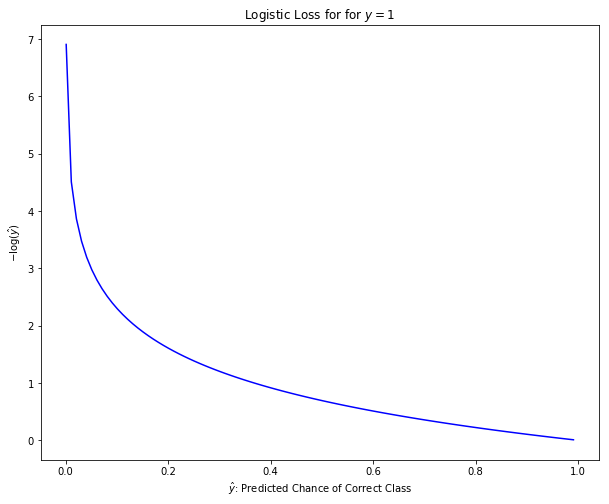

In [214]:
y_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(y_hat)
plt.plot(y_hat, loss, color='b')
plt.xlabel('$\hat{y}$: Predicted Chance of Correct Class')
plt.ylabel('$-\log(\hat{y})$')
plt.title('Logistic Loss for for $y=1$');

In [70]:
-np.log(0.05)

2.995732273553991

How should we understand the chart? 

Suppose the observation $y$ we're trying to predict equals 1. 

- If the predicted value $\hat{y}$ is 0.8, then the loss $-\operatorname{log}(\hat{y})$ is small around 0.25. 
- If the predicted value $\hat{y}$ is 0.4, then the loss $-\operatorname{log}(\hat{y})$ is larger around 1. 
- If the predicted value $\hat{y}$ is only 0.05, then the loss $-\operatorname{log}(\hat{y})$ is larger around 3. 
- And if we give a 0.0 probability of the value 1, then loss is infinite.

So we learn that logistic loss strongly penalizes bad predictions. Let's try plotting the average logistic loss on our NBA data example. 

In [215]:
def logistic_loss(y, y_hat):
    return -y * np.log(y_hat) - (1-y) * np.log(1-y_hat)

def logistic_loss_single_arg(w):
    x = games["FG_PCT_DIFF"]
    y_obs = games["WON_FIRST"]
    y_hat = sigma(w * x)
    return np.mean(cross_entropy_loss(y_obs, y_hat))

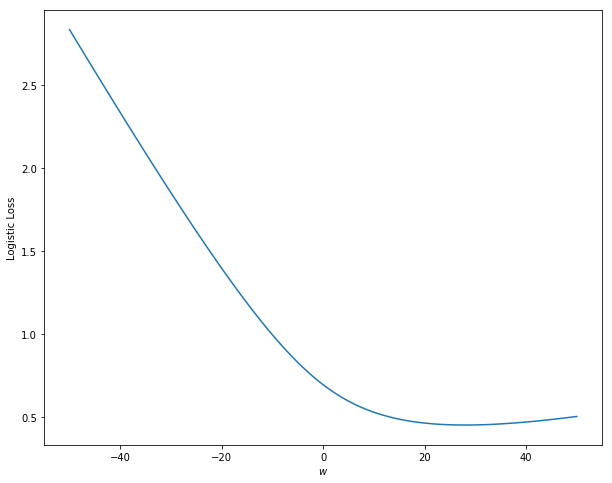

In [217]:
w_values = np.linspace(-50, 50, 100)
plt.plot(w_values, [logistic_loss_single_arg(w) for w in w_values])
plt.ylabel('Logistic Loss')
plt.xlabel(r'$w$');

The logistic loss function is convex meaning it bends upwards from its minimum value. In particular, we do not have flat regions where gradient descent gets stuck.

In [153]:
minimize(cross_entropy_loss_single_arg, x0 = 0).x

array([27.91536894])

We learn that the value for the parameter $w$ should be 27.9

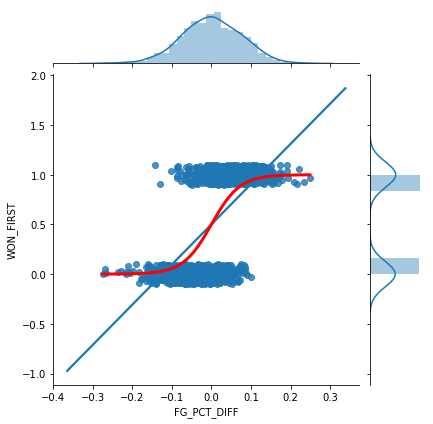

In [218]:
sns.jointplot(data = games, x = "FG_PCT_DIFF", y = "WON_FIRST", kind="reg", y_jitter = 0.1, ci = 0)
x = np.sort(games["FG_PCT_DIFF"])
plt.plot(x, sigma(x * 27.91536894), 'r', linewidth = 3);